<a href="https://colab.research.google.com/github/nnson0511/LDA-on-Spark/blob/main/LDA_on_spark_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import urllib.request
from textblob import TextBlob
import seaborn as sns
import time

import re
import nltk
import spacy
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')

import gensim
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Tiền xử lý dữ liệu

In [ ]:
df = pd.read_csv('/content/sotu_texts.csv')
df

,President,Year,Title,Text
0,George Washington,1790,First State of the Union Address,['I embrace with great satisfaction the opport...
1,George Washington,1790,Second State of the Union Address,['Fellow-Citizens of the Senate and the House ...
2,George Washington,1791,Third State of the Union Address,['Fellow-Citizens of the Senate and the House ...
3,George Washington,1792,Fourth State of the Union Address,['Fellow-Citizens of the Senate and of the Hou...
4,George Washington,1793,Fifth State of the Union Address,['Fellow Citizens of the Senate and of the Hou...
...,...,...,...,...
215,Barack Obama,2016,Barack Obama's Eighth State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
216,Donald Trump,2017,Donald Trump's First State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
217,Donald Trump,2018,Donald Trump's Second State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
218,Donald Trump,2019,Donald Trump's Third State of the Union Address,"['Madam Speaker, Mr. Vice President, Members o..."


In [ ]:
# Tính số lượng từ trong mỗi hàng
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))

# Tìm số lượng từ tối thiểu và tối đa
min_word_count = df['word_count'].min()
max_word_count = df['word_count'].max()

print(f"Minimum word count: {min_word_count}")
print(f"Maximum word count: {max_word_count}")

Minimum word count: 1067
Maximum word count: 33577


In [ ]:
# Preprocess pipeline with nltk:
def nltk_preprocess(text):
    # Chuyển đổi văn bản thành chữ thường
    text = text.lower()
    # Loại bỏ dấu câu và ký tự đặc biệt
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenize văn bản
    tokens = word_tokenize(text)
    # Loại bỏ stopwords và dấu câu
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    # Lemmatization (Steming)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner']) # disabling the parser makes it run faster
# Preprocess pipeline with spacy:
def spacy_preprocess(text):
    text_out = []
    for token in nlp(text.lower()):
        # Loại bỏ stopwords và ký tự không phải chữ và số
        if not token.is_stop and token.is_alpha and len(token)>1:
            lemma = token.lemma_
            if lemma != '-PRON-':
                text_out.append(lemma)
            else:
                text_out.append(token.text)
    return(text_out)

In [ ]:
df['nltk_tokens'] = df['Text'].apply(nltk_preprocess)
df['spacy_tokens'] = df['Text'].apply(spacy_preprocess)

df

,President,Year,Title,Text,word_count,nltk_tokens,spacy_tokens
0,George Washington,1790,First State of the Union Address,['I embrace with great satisfaction the opport...,1067,"[embrac, great, satisfact, opportun, present, ...","[embrace, great, satisfaction, opportunity, pr..."
1,George Washington,1790,Second State of the Union Address,['Fellow-Citizens of the Senate and the House ...,1404,"[fellowcitizen, senat, hous, repres, meet, fee...","[fellow, citizen, senate, house, representativ..."
2,George Washington,1791,Third State of the Union Address,['Fellow-Citizens of the Senate and the House ...,2260,"[fellowcitizen, senat, hous, repres, meet, upo...","[fellow, citizen, senate, house, representativ..."
3,George Washington,1792,Fourth State of the Union Address,['Fellow-Citizens of the Senate and of the Hou...,2100,"[fellowcitizen, senat, hous, repres, abat, sat...","[fellow, citizen, senate, house, representativ..."
4,George Washington,1793,Fifth State of the Union Address,['Fellow Citizens of the Senate and of the Hou...,1968,"[fellow, citizen, senat, hous, repres, sinc, c...","[fellow, citizen, senate, house, representativ..."
...,...,...,...,...,...,...,...
215,Barack Obama,2016,Barack Obama's Eighth State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",5465,"[mr, speaker, mr, vice, presid, member, congre...","[mr, speaker, mr, vice, president, member, con..."
216,Donald Trump,2017,Donald Trump's First State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",5022,"[mr, speaker, mr, vice, presid, member, congre...","[mr, speaker, mr, vice, president, member, con..."
217,Donald Trump,2018,Donald Trump's Second State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",5185,"[mr, speaker, mr, vice, presid, member, congre...","[mr, speaker, mr, vice, president, member, con..."
218,Donald Trump,2019,Donald Trump's Third State of the Union Address,"['Madam Speaker, Mr. Vice President, Members o...",5147,"[madam, speaker, mr, vice, presid, member, con...","[madam, speaker, mr, vice, president, member, ..."


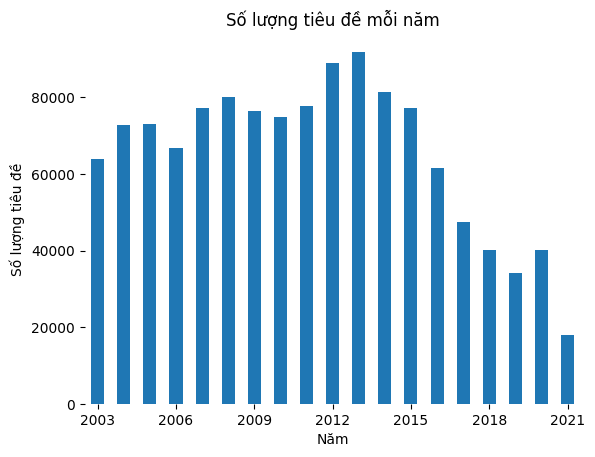

In [ ]:
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y%m%d')

df['year'] = df['publish_date'].dt.year

headlines_per_year = df.groupby('year')['headline_text'].count()

fig, ax = plt.subplots()
headlines_per_year.plot(kind='bar', ax=ax)
ax.set_title('Số lượng tiêu đề mỗi năm')
ax.set_xlabel('Năm')
ax.set_ylabel('Số lượng tiêu đề')
ax.set_xticklabels(headlines_per_year.index, rotation=0)

if len(headlines_per_year) > 10:
    ax.set_xticks(ax.get_xticks()[::3])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()

# Triển khai Mô hình LDA tuần tự

In [ ]:
# Tạo từ điển dựa trên cột 'tokens'
gensim_dictionary = corpora.Dictionary(df['spacy_tokens'])

# Tạo document-term matrix (corpus) dựa trên cột 'tokens'
gensim_corpus = [gensim_dictionary.doc2bow(text) for text in df['spacy_tokens']]

# Xác định số lượng chủ đề
num_topics = 10

# Xây dựng mô hình LDA
gensimLDA = LdaModel(corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=num_topics, random_state=42)

In [ ]:
# Lấy phân phối chủ đề cho một văn bản cụ thể
document = df.loc[0, 'Text'].split()
doc_bow = gensim_dictionary.doc2bow(document)
topic_distribution = gensimLDA.get_document_topics(doc_bow)

In [ ]:
# In ra các chủ đề và các từ quan trọng nhất trong mỗi chủ đề
for topic_num, topic_words in gensimLDA.show_topics(num_topics=num_topics, num_words=12, formatted=False):
    print(f"Topic {topic_num + 1}:")
    for word, prob in topic_words:
        prob_percentage = prob * 100
        print(f"{word}: {prob_percentage:.2f}%")
    print()

Topic 1:
government: 1.19%
year: 0.90%
united: 0.73%
congress: 0.63%
state: 0.61%
country: 0.54%
states: 0.50%
great: 0.50%
law: 0.49%
people: 0.47%
nation: 0.46%
public: 0.45%

Topic 2:
government: 1.04%
united: 0.79%
congress: 0.64%
great: 0.55%
law: 0.55%
country: 0.54%
states: 0.53%
people: 0.49%
year: 0.48%
nation: 0.43%
act: 0.41%
new: 0.41%

Topic 3:
government: 1.13%
year: 0.99%
united: 0.64%
states: 0.64%
law: 0.53%
great: 0.53%
state: 0.52%
country: 0.50%
people: 0.49%
american: 0.47%
nation: 0.46%
congress: 0.46%

Topic 4:
government: 1.09%
congress: 0.85%
people: 0.63%
year: 0.60%
country: 0.59%
great: 0.59%
nation: 0.55%
state: 0.54%
war: 0.53%
public: 0.52%
united: 0.50%
time: 0.49%

Topic 5:
government: 0.82%
year: 0.81%
united: 0.66%
congress: 0.66%
great: 0.55%
country: 0.51%
nation: 0.51%
states: 0.51%
state: 0.50%
work: 0.47%
people: 0.43%
public: 0.42%

Topic 6:
year: 0.97%
government: 0.86%
congress: 0.61%
state: 0.60%
people: 0.58%
nation: 0.57%
country: 0.57%
sta

# Triển khai Mô hình LDA song song dùng pyspark

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=492a357a0e3d8dc4bedc15d66ec3698c088645d131e9c4872cec7731329cfe89
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import LDA


In [ ]:
# Ví dụ cho việc tạo 1 session có kết nối đến master và setting cho các executor
# spark = SparkSession \
#     .builder \
#     .appName("abcNews LDA Analysis") \
#     .master("spark://MASTER_NODE_IP:PORT") \
#     .config("spark.executor.memory", "4g") \
#     .config("spark.executor.cores", "2") \
#     .config("spark.shuffle.service.enabled", "true") \
#     .config("spark.dynamicAllocation.enabled", "true") \
#     .config("spark.dynamicAllocation.initialExecutors", "2") \
#     .config("spark.dynamicAllocation.minExecutors", "1") \
#     .config("spark.dynamicAllocation.maxExecutors", "10") \
#     .getOrCreate()

In [ ]:
spark = SparkSession.builder.appName('sotu_texts').getOrCreate()
tokens_df = spark.createDataFrame(df)
tokens_df.show(5)

+-----------------+----+--------------------+--------------------+----------+--------------------+--------------------+
|        President|Year|               Title|                Text|word_count|         nltk_tokens|        spacy_tokens|
+-----------------+----+--------------------+--------------------+----------+--------------------+--------------------+
|George Washington|1790|First State of th...|['I embrace with ...|      1067|[embrac, great, s...|[embrace, great, ...|
|George Washington|1790|Second State of t...|['Fellow-Citizens...|      1404|[fellowcitizen, s...|[fellow, citizen,...|
|George Washington|1791|Third State of th...|['Fellow-Citizens...|      2260|[fellowcitizen, s...|[fellow, citizen,...|
|George Washington|1792|Fourth State of t...|['Fellow-Citizens...|      2100|[fellowcitizen, s...|[fellow, citizen,...|
|George Washington|1793|Fifth State of th...|['Fellow Citizens...|      1968|[fellow, citizen,...|[fellow, citizen,...|
+-----------------+----+----------------

In [ ]:
# Khởi tạo một đối tượng CountVectorizer với cột đầu vào là 'tokens', cột đầu ra là 'features'.
# vocabSize là số lượng từ tối đa trong từ điển. minDF là tần suất tối thiểu của một từ để được đưa vào từ điển.
cv = CountVectorizer(inputCol="spacy_tokens", outputCol="features", vocabSize=500, minDF=3.0)

# Áp dụng CountVectorizer để 'fit' dữ liệu từ DataFrame 'tokens_df', tức là học từ điển từ dữ liệu.
cv_model = cv.fit(tokens_df)

# Transform DataFrame 'tokens_df' sử dụng mô hình CountVectorizer để chuyển đổi cột 'tokens' thành cột 'features'.
# Cột 'features' sẽ chứa vector đếm số lần xuất hiện của mỗi từ trong mỗi tài liệu.
vectorized_tokens = cv_model.transform(tokens_df)

# Hiển thị 5 hàng đầu tiên của DataFrame sau khi đã áp dụng vector hóa.
vectorized_tokens.show(5)

+-----------------+----+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|        President|Year|               Title|                Text|word_count|         nltk_tokens|        spacy_tokens|            features|
+-----------------+----+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|George Washington|1790|First State of th...|['I embrace with ...|      1067|[embrac, great, s...|[embrace, great, ...|(500,[0,3,4,5,6,7...|
|George Washington|1790|Second State of t...|['Fellow-Citizens...|      1404|[fellowcitizen, s...|[fellow, citizen,...|(500,[0,1,2,3,4,5...|
|George Washington|1791|Third State of th...|['Fellow-Citizens...|      2260|[fellowcitizen, s...|[fellow, citizen,...|(500,[0,1,2,3,4,5...|
|George Washington|1792|Fourth State of t...|['Fellow-Citizens...|      2100|[fellowcitizen, s...|[fellow, citizen,...|(500,[0,1,2,3,4,5...|
|George Washi

In [ ]:
# Đặt số lượng chủ đề cần tìm
num_topics = 10

# Khởi tạo mô hình LDA với số lượng chủ đề (k) và số lần lặp tối đa (maxIter)
lda = LDA(k=num_topics, maxIter=50)

# Áp dụng mô hình LDA lên DataFrame đã được vector hóa để tìm các chủ đề
model = lda.fit(vectorized_tokens)

# Xuất mô hình sau khi đã được fit
model

LocalLDAModel: uid=LDA_df771d5638b4, k=10, numFeatures=500

In [ ]:
# Lấy vocabulary từ CountVectorizer model
vocab = cv_model.vocabulary

# Mô tả các chủ đề được tìm thấy bởi LDA model
topics = model.describeTopics()

# Chuyển đổi DataFrame của Spark thành RDD (Resilient Distributed Dataset)
# và áp dụng một hàm để lấy ra chỉ số của các thuật ngữ (term indices) cho mỗi chủ đề
# sau đó thu thập kết quả về máy local
collected_topics = topics.rdd\
    .map(lambda row: (row['topic'], row['termIndices'], row['termWeights']))\
    .collect()

# Trích xuất và chuyển đổi các chỉ số thuật ngữ thành từ tương ứng từ vocabulary
topics_words = topics.rdd\
    .map(lambda row: row['termIndices'])\
    .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
    .collect()


In [ ]:
# In thông tin chủ đề
for topic, term_indices, term_weights in collected_topics:
    print(f"Topic {topic + 1}:")
    for idx, weight in zip(term_indices, term_weights):
        print(f" {vocab[idx]}: {weight*100:.2f}%")
    print()

Topic 1:
 year: 0.57%
 congress: 0.50%
 state: 0.50%
 great: 0.48%
 subject: 0.46%
 government: 0.45%
 law: 0.43%
 war: 0.42%
 service: 0.41%
 measure: 0.40%

Topic 2:
 government: 1.29%
 year: 0.98%
 states: 0.86%
 people: 0.83%
 united: 0.76%
 country: 0.71%
 new: 0.67%
 american: 0.67%
 congress: 0.59%
 good: 0.58%

Topic 3:
 government: 2.24%
 year: 1.92%
 congress: 1.63%
 country: 1.21%
 increase: 1.06%
 service: 0.97%
 united: 0.97%
 law: 0.92%
 states: 0.84%
 national: 0.83%

Topic 4:
 government: 2.02%
 war: 1.78%
 congress: 1.58%
 state: 1.56%
 nation: 1.54%
 united: 1.25%
 shall: 1.23%
 power: 1.19%
 people: 1.17%
 great: 1.15%

Topic 5:
 government: 2.28%
 states: 2.02%
 united: 1.92%
 state: 1.53%
 year: 1.36%
 congress: 1.25%
 country: 1.17%
 great: 1.01%
 subject: 0.90%
 law: 0.88%

Topic 6:
 government: 1.75%
 law: 1.57%
 man: 1.38%
 great: 1.37%
 work: 1.06%
 country: 0.97%
 year: 0.93%
 people: 0.87%
 good: 0.84%
 condition: 0.81%

Topic 7:
 year: 2.36%
 people: 1.88%


In [ ]:
topics

DataFrame[topic: int, termIndices: array<int>, termWeights: array<double>]

In [ ]:
collected_topics

[[140, 201, 213, 263, 180, 199, 366, 365, 458, 420],
 [31, 76, 87, 59, 99, 102, 141, 154, 65, 197],
 [42, 61, 63, 103, 137, 165, 192, 220, 236, 231],
 [8, 17, 14, 29, 40, 45, 50, 47, 104, 100],
 [35, 73, 89, 88, 133, 135, 151, 169, 72, 160],
 [18, 51, 71, 70, 77, 93, 212, 218, 179, 264],
 [23, 41, 83, 106, 210, 239, 188, 260, 285, 297],
 [15, 26, 28, 38, 95, 80, 108, 112, 68, 129],
 [22, 49, 21, 56, 24, 82, 119, 36, 122, 193],
 [46, 78, 91, 109, 94, 114, 152, 153, 168, 249],
 [75, 189, 243, 257, 300, 320, 398, 404, 383, 379],
 [86, 158, 155, 178, 219, 253, 399, 395, 436, 413],
 [4, 16, 9, 39, 62, 96, 97, 115, 134, 157],
 [0, 6, 43, 55, 84, 11, 52, 107, 120, 125],
 [3, 110, 163, 173, 252, 338, 400, 406, 416, 363],
 [34, 30, 101, 123, 131, 147, 162, 202, 254, 296],
 [2, 5, 19, 33, 48, 58, 90, 57, 113, 11],
 [12, 27, 25, 37, 66, 156, 161, 186, 191, 175],
 [7, 10, 74, 117, 92, 164, 221, 240, 228, 234],
 [1, 13, 20, 60, 81, 111, 127, 138, 145, 146]]

In [ ]:
topics_words

[['dead',
  'leav',
  'shoot',
  'season',
  'bushfir',
  'three',
  'extend',
  'nrl',
  'shot',
  'five'],
 ['attack',
  'job',
  'worker',
  'cut',
  'power',
  'one',
  'adelaid',
  'train',
  'two',
  'appeal'],
 ['elect',
  'set',
  'rise',
  'nt',
  'commun',
  'live',
  'student',
  'vote',
  'prison',
  'begin'],
 ['australia',
  'interview',
  'back',
  'year',
  'hit',
  'market',
  'world',
  'govern',
  'cup',
  'fight'],
 ['take',
  'found',
  'road',
  'melbourn',
  'abc',
  'top',
  'close',
  'still',
  'minist',
  'park'],
 ['australian',
  'nation',
  'farmer',
  'china',
  'coronaviru',
  'record',
  'victoria',
  'island',
  'trump',
  'covid'],
 ['warn',
  'mine',
  'final',
  'trial',
  'delay',
  'cost',
  'review',
  'dog',
  'peopl',
  'blaze'],
 ['nsw',
  'sydney',
  'get',
  'day',
  'arrest',
  'flood',
  'labor',
  'lead',
  'case',
  'time'],
 ['crash',
  'hospit',
  'face',
  'accus',
  'fund',
  'protest',
  'pm',
  'open',
  'end',
  'aussi'],
 ['miss'